*Attribution:*

*https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

*https://arxiv.org/abs/1605.07146*

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# **Training**

In [ ]:
transform = [
  transforms.ToTensor(),
    # rescale from [0, 255] to pre-defined means and stds
  transforms.Normalize(
    np.array([125.3, 123.0, 113.9]) / 255.0,
    np.array([63.0, 62.1, 66.7]) / 255.0,
  ),
]

train_transform = transforms.Compose(transform + [
  # pad to allow room for random crop
  transforms.Pad(4, padding_mode="reflect"),
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32),
  # transforms.ColorJitter(
  #   brightness=.2,
  #   contrast=.2,
  #   saturation=.2,
  #   hue=.2,
  # ),
  transforms.RandomRotation(15),
])

batch_size = 128

train_data = torchvision.datasets.CIFAR10(
  root=".",
  train=True,
  download=True,
  transform=train_transform,
)
train_loader = torch.utils.data.DataLoader(
  train_data,
  batch_size=batch_size,
  shuffle=True,
  num_workers=2,
)

# test transform should only have the rescale transform, nothing else
test_transform = transforms.Compose(transform)

test_data = torchvision.datasets.CIFAR10(
  root=".",
  train=False,
  download=True,
  transform=test_transform,
)
test_loader = torch.utils.data.DataLoader(
  test_data,
  batch_size=batch_size,
  shuffle=False,
  num_workers=2,
)

In [3]:
class Block(nn.Module):
  def __init__(self, n_in, n_out, stride):
    super().__init__()
    self.bn0 = nn.BatchNorm2d(n_in)
    self.conv0 = nn.Conv2d(n_in, n_out, 3, stride=stride, padding=1)
    self.bn1 = nn.BatchNorm2d(n_out)
    self.conv1 = nn.Conv2d(n_out, n_out, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(n_in, n_out, 1, stride=stride) if n_in != n_out else None

  def forward(self, x):
    o1 = F.relu(self.bn0(x))
    y = self.conv0(o1)
    o2 = F.relu(self.bn1(y))
    z = self.conv1(o2)
    # residual connection
    out = z + self.conv2(x) if self.conv2 else z + x
    return out

class Group(nn.Module):
  def __init__(self, n, n_in, n_out, stride):
    super().__init__()
    self.n = n
    self.blocks = nn.ModuleList()
    # a group consists of n blocks
    for i in range(self.n):
      # n_in needs to be adjusted accordingly to keep dimensions consistent
      self.blocks.append(Block(n_in if i == 0 else n_out, n_out, stride if i == 0 else 1))

  def forward(self, x):
    for i in range(self.n):
      x = self.blocks[i](x)
    return x

class Model(nn.Module):
  def __init__(self, depth, width):
    super().__init__()
    n = (depth - 4) // 6
    widths = [v * width for v in [16, 32, 64]]

    self.conv0 = nn.Conv2d(3, 16, 3, padding=1)

    self.g0 = Group(n, 16, widths[0], 1)
    self.g1 = Group(n, widths[0], widths[1], 2)
    self.g2 = Group(n, widths[1], widths[2], 2)

    self.bn = nn.BatchNorm2d(widths[2])
    self.avg = nn.AvgPool2d(8, 1, 0)
    # cifar10 has 10 output classes
    self.linear = nn.Linear(widths[2], 10)

  def forward(self, x):
    x = self.conv0(x)
    x = self.g0(x)
    x = self.g1(x)
    x = self.g2(x)
    x = F.relu(self.bn(x))
    x = self.avg(x)
    x = torch.flatten(x, 1)
    # no need for softmax, loss includes softmax
    x = self.linear(x)
    return x

In [4]:
model = Model(depth=40, width=2)
summary(model, tuple(next(iter(train_loader))[0].shape[1:]), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 32, 32, 32]           4,640
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,248
            Conv2d-6           [-1, 32, 32, 32]             544
             Block-7           [-1, 32, 32, 32]               0
       BatchNorm2d-8           [-1, 32, 32, 32]              64
            Conv2d-9           [-1, 32, 32, 32]           9,248
      BatchNorm2d-10           [-1, 32, 32, 32]              64
           Conv2d-11           [-1, 32, 32, 32]           9,248
            Block-12           [-1, 32, 32, 32]               0
      BatchNorm2d-13           [-1, 32, 32, 32]              64
           Conv2d-14           [-1, 32,

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
  model.parameters(),
  lr=.1,
  momentum=.9,
  weight_decay=.0005,
)
# learning rate decreases by .2x at epochs 60, 120, and 160
scheduler = optim.lr_scheduler.MultiStepLR(
  optimizer,
  milestones=[60, 120, 160],
  gamma=.2,
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_losses, train_accs, test_losses, test_accs = [], [], [], []
epochs = 200

best = 0
for epoch in range(epochs):
  model.train()
  with tqdm(total=len(train_loader)) as pbar:
    total_loss, correct, total = 0, 0, 0
    for data in train_loader:
      inputs, labels = data[0].to(device), data[1].to(device)
      # reset the optimizer
      optimizer.zero_grad()
      # calculate the outputs
      outputs = model(inputs)
      # calculate the loss by comparing against labels
      loss = criterion(outputs, labels)
      # backpropagation
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

      # prediction is the index of the max probability
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      train_losses.append(loss.item())
      pbar.update(1)
      pbar.set_description(
        f"Epoch {epoch}"
        + f" - Train Loss {loss.item()}"
      )
    # update the epoch so the scheduler updates the learning rate accordingly
    scheduler.step()

    train_accs.append(correct / total)
    pbar.set_description(
      f"Epoch {epoch}"
      + f" - Train Loss {total_loss / len(train_loader)}"
      + f" - Train Accuracy {correct / total}"
    )

    total_test_loss, test_correct, test_total = 0, 0, 0
    # eval mode for certain model aspects like batchnorm
    model.eval()
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()
        test_losses.append(loss.item())

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_accs.append(test_correct / test_total)
    pbar.set_description(
      f"Epoch {epoch}"
      + f" - Train Loss {total_loss / len(train_loader)}"
      + f" - Train Accuracy {correct / total}"
      + f" - Test Loss {total_test_loss / len(test_loader)}"
      + f" - Test Accuracy {test_correct / test_total}"
    )

    if test_correct / test_total > best:
      best = test_correct / test_total
      # torch.save(model.state_dict(), "/")

Max train accuracy 0.99754 - Max test accuracy 0.9525


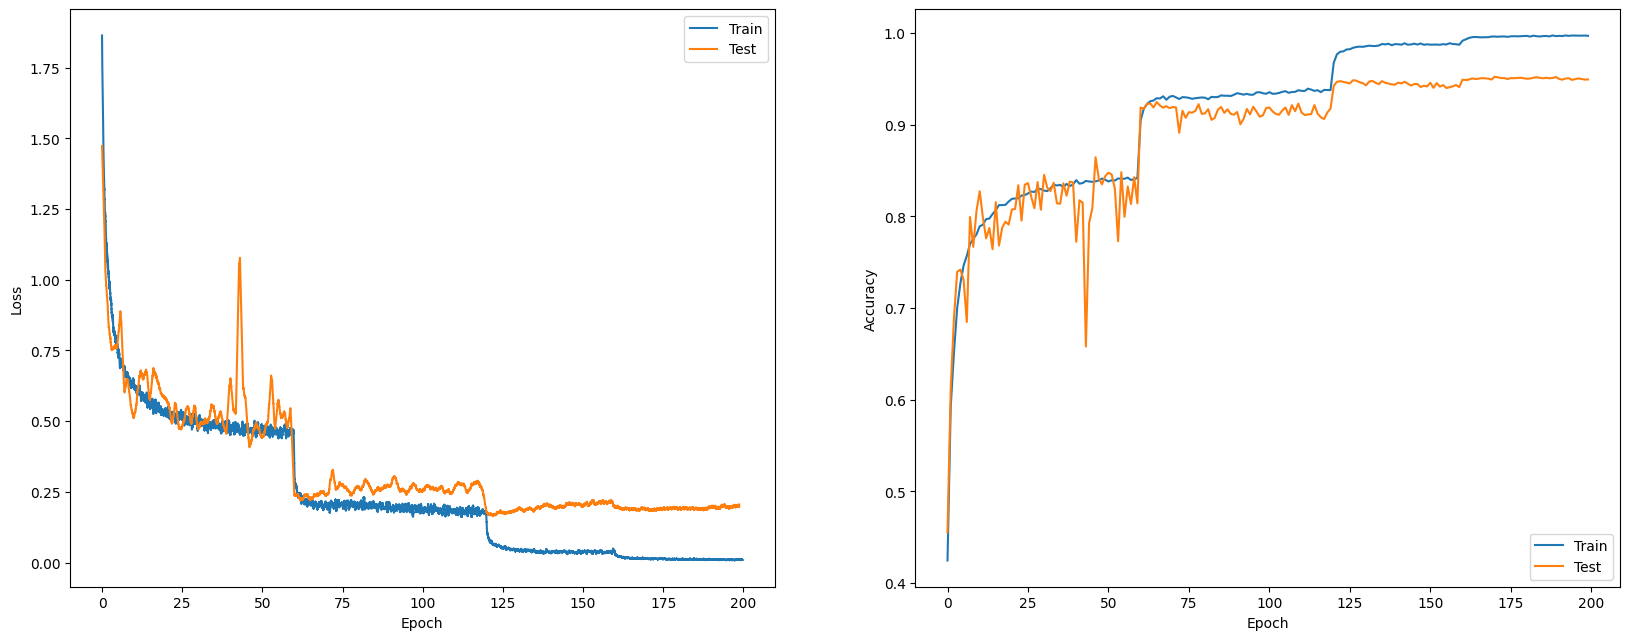

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7.5))
# smooth the loss curves by using a moving average, they look messy
window = 100
# for loss, we have data for each batch, create a range from [0, epochs] and divide accordingly
ax[0].plot(np.arange(0, epochs, 1 / len(train_loader))[:-window + 1], np.convolve(train_losses, np.ones(window) / window, mode="valid"), label="Train")
ax[0].plot(np.arange(0, epochs, 1 / len(test_loader))[:-window + 1], np.convolve(test_losses, np.ones(window) / window, mode="valid"), label="Test")
ax[0].legend(loc="upper right")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].plot(list(range(epochs)), train_accs, label="Train")
ax[1].plot(list(range(epochs)), test_accs, label="Test")
ax[1].legend(loc="lower right")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
print(f"Max train accuracy {max(train_accs)} - Max test accuracy {max(test_accs)}")

# **Evaluation**

In [21]:
import pickle
import csv

In [22]:
with open("/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl", "rb") as f:
  test_set = pickle.load(f, encoding="bytes")

In [23]:
test_data = torch.zeros((10000, 3, 32, 32))
for i, img in enumerate(test_set[b"data"]):
  # apply the same test set transform
  test_data[i] = test_transform(img)

In [24]:
test_loader = torch.utils.data.DataLoader(
  test_data,
  batch_size=batch_size,
  shuffle=False,
  num_workers=2,
)

In [25]:
output = {}

model.eval()
with torch.no_grad():
  for i, data in enumerate(test_loader):
    images = data.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # since predictions are batched, keep track of which IDs are part of batch
    for j, id in enumerate(test_set[b"ids"][i*batch_size:i*batch_size+len(predicted)]):
      output[id] = predicted[j].item()

In [26]:
with open("output.csv", "w") as csv_file:
  writer = csv.writer(csv_file)
  writer.writerow(["ID", "Labels"])
  for key, val in output.items():
    writer.writerow([key, val])